In [1]:
import numpy as np
import json
import colorsys
import matplotlib.pyplot as plt

### This Notebook is used for small utility tasks that need to be executed only once


In [7]:
# Load the training JSON file
with open("/globalwork/fradlin/mask4d-interactive/processed/semantic_kitti/full_train_list.json", "r") as f:
    data = json.load(f)

# Initialize a variable to track the maximum length
max_length = 0
min_length = 1000000
max_key = None
min_key = None
running_average = 0
counter = 0

# Iterate over all the keys in the JSON data
for key, value in data.items():
    if "unique_panoptic_labels" in value:
        # Calculate the length of the unique_panoptic_labels list
        length = len(value["unique_panoptic_labels"])
        # Update max_length if the current length is greater
        if length > max_length:
            max_length = length
            max_key = key
        if length < min_length:
            min_length = length
            min_key = key
        running_average += length
        counter += 1

average = running_average / counter

print("stats for training set")
print(f"The average number of unique_panoptic_labels is: {average}")
print(f"The key with the largest unique_panoptic_labels is: {max_key}")
print(f"The largest number of unique_panoptic_labels is: {max_length}")
print(f"The key with the smallest unique_panoptic_labels is: {min_key}")
print(f"The smallest number of unique_panoptic_labels is: {min_length}")

stats for training set
The average number of unique_panoptic_labels is: 19.813904861474125
The key with the largest unique_panoptic_labels is: scene_00_001472
The largest number of unique_panoptic_labels is: 66
The key with the smallest unique_panoptic_labels is: scene_02_001856
The smallest number of unique_panoptic_labels is: 4


In [8]:
# Load the validation JSON file
with open("/globalwork/fradlin/mask4d-interactive/processed/semantic_kitti/full_validation_list.json", "r") as f:
    data = json.load(f)

# Initialize a variable to track the maximum length
max_length = 0
min_length = 1000000
max_key = None
min_key = None
running_average = 0
counter = 0

# Iterate over all the keys in the JSON data
for key, value in data.items():
    if "unique_panoptic_labels" in value:
        # Calculate the length of the unique_panoptic_labels list
        length = len(value["unique_panoptic_labels"])
        # Update max_length if the current length is greater
        if length > max_length:
            max_length = length
            max_key = key
        if length < min_length:
            min_length = length
            min_key = key
        running_average += length
        counter += 1

average = running_average / counter

print("stats for validation set")
print(f"The average number of unique_panoptic_labels is: {average}")
print(f"The key with the largest unique_panoptic_labels is: {max_key}")
print(f"The largest number of unique_panoptic_labels is: {max_length}")
print(f"The key with the smallest unique_panoptic_labels is: {min_key}")
print(f"The smallest number of unique_panoptic_labels is: {min_length}")

stats for validation set
The average number of unique_panoptic_labels is: 24.574551707197248
The key with the largest unique_panoptic_labels is: scene_08_004000
The largest number of unique_panoptic_labels is: 54
The key with the smallest unique_panoptic_labels is: scene_08_000236
The smallest number of unique_panoptic_labels is: 11


### Generate n visually seperable RGB colors


In [17]:
def generate_distinct_colors(n):
    # Generate colors in HSL color space and convert to RGB
    colors = []
    for i in range(n):
        hue = i / n
        lightness = 0.5
        saturation = 0.9
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        rgb = tuple(int(255 * x) for x in rgb)
        colors.append(rgb)
    return colors


# Example usage
n = 70
distinct_colors = generate_distinct_colors(n)
for i, color in enumerate(distinct_colors):
    print(f"Color {i}: {color}")

Color 0: (242, 12, 12)
Color 1: (242, 32, 12)
Color 2: (242, 52, 12)
Color 3: (242, 71, 12)
Color 4: (242, 91, 12)
Color 5: (242, 111, 12)
Color 6: (242, 130, 12)
Color 7: (242, 150, 12)
Color 8: (242, 170, 12)
Color 9: (242, 189, 12)
Color 10: (242, 209, 12)
Color 11: (242, 229, 12)
Color 12: (235, 242, 12)
Color 13: (216, 242, 12)
Color 14: (196, 242, 12)
Color 15: (176, 242, 12)
Color 16: (157, 242, 12)
Color 17: (137, 242, 12)
Color 18: (117, 242, 12)
Color 19: (97, 242, 12)
Color 20: (78, 242, 12)
Color 21: (58, 242, 12)
Color 22: (38, 242, 12)
Color 23: (19, 242, 12)
Color 24: (12, 242, 25)
Color 25: (12, 242, 45)
Color 26: (12, 242, 65)
Color 27: (12, 242, 84)
Color 28: (12, 242, 104)
Color 29: (12, 242, 124)
Color 30: (12, 242, 143)
Color 31: (12, 242, 163)
Color 32: (12, 242, 183)
Color 33: (12, 242, 202)
Color 34: (12, 242, 222)
Color 35: (12, 242, 242)
Color 36: (12, 222, 242)
Color 37: (12, 202, 242)
Color 38: (12, 183, 242)
Color 39: (12, 163, 242)
Color 40: (12, 143, 242)

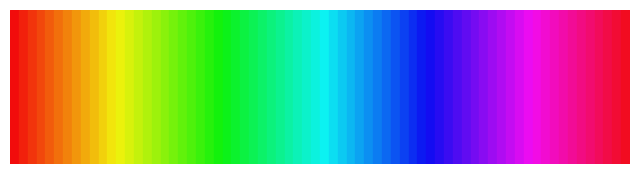

In [18]:
def plot_colors(colors):
    fig, ax = plt.subplots(figsize=(8, 2))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=[c / 255.0 for c in color]))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.axis("off")
    plt.show()


plot_colors(distinct_colors)

In [11]:
import matplotlib.pyplot as plt


class IntensityValue:
    def __init__(self, parent, value, level):
        if level > 7:
            raise Exception("There are no more colours left")
        self.value = value
        self.parent = parent
        self.level = level
        self._child_a = None
        self._child_b = None

    @property
    def child_a(self):
        if self._child_a is None:
            self._child_a = IntensityValue(self, self.value - (1 << (7 - self.level)), self.level + 1)
        return self._child_a

    @property
    def child_b(self):
        if self._child_b is None:
            self._child_b = IntensityValue(self, self.value + (1 << (7 - self.level)), self.level + 1)
        return self._child_b


class IntensityValueWalker:
    def __init__(self):
        self.current = IntensityValue(None, 1 << 7, 1)

    def move_next(self):
        if self.current.parent is None:
            self.current = self.current.child_a
        elif self.current.parent.child_a == self.current:
            self.current = self.current.parent.child_b
        else:
            levels_up = 1
            self.current = self.current.parent
            while self.current.parent is not None and self.current == self.current.parent.child_b:
                self.current = self.current.parent
                levels_up += 1
            if self.current.parent is not None:
                self.current = self.current.parent.child_b
            else:
                levels_up += 1
            for _ in range(levels_up):
                self.current = self.current.child_a


class ColourGenerator:
    def __init__(self):
        self.index = 0
        self.intensity_generator = IntensityValueWalker()
        self.patterns = ["{0}0000", "00{0}00", "0000{0}", "{0}{0}00", "{0}00{0}", "00{0}{0}", "{0}{0}{0}"]

    def next_colour(self):
        intensity = self.next_intensity(self.index)
        pattern = self.patterns[self.index % 7]
        colour = pattern.format(intensity)
        self.index += 1
        return colour

    def next_intensity(self, index):
        if index == 0:
            self.current_intensity = 255
        elif index % 7 == 0:
            self.intensity_generator.move_next()
            self.current_intensity = self.intensity_generator.current.value
        current_text = hex(self.current_intensity)[2:].upper()
        if len(current_text) == 1:
            current_text = "0" + current_text
        return current_text


def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i : i + 2], 16) for i in (0, 2, 4))


def plot_colors(colors):
    fig, ax = plt.subplots(figsize=(15, 5))
    for i, color in enumerate(colors):
        rgb = hex_to_rgb(color)
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=[c / 255.0 for c in rgb]))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.axis("off")
    plt.show()

Color 0: (255, 0, 0)
Color 1: (0, 255, 0)
Color 2: (0, 0, 255)
Color 3: (255, 255, 0)
Color 4: (255, 0, 255)
Color 5: (0, 255, 255)
Color 6: (255, 255, 255)
Color 7: (64, 0, 0)
Color 8: (0, 64, 0)
Color 9: (0, 0, 64)
Color 10: (64, 64, 0)
Color 11: (64, 0, 64)
Color 12: (0, 64, 64)
Color 13: (64, 64, 64)
Color 14: (192, 0, 0)
Color 15: (0, 192, 0)
Color 16: (0, 0, 192)
Color 17: (192, 192, 0)
Color 18: (192, 0, 192)
Color 19: (0, 192, 192)
Color 20: (192, 192, 192)
Color 21: (32, 0, 0)
Color 22: (0, 32, 0)
Color 23: (0, 0, 32)
Color 24: (32, 32, 0)
Color 25: (32, 0, 32)
Color 26: (0, 32, 32)
Color 27: (32, 32, 32)
Color 28: (96, 0, 0)
Color 29: (0, 96, 0)
Color 30: (0, 0, 96)
Color 31: (96, 96, 0)
Color 32: (96, 0, 96)
Color 33: (0, 96, 96)
Color 34: (96, 96, 96)
Color 35: (160, 0, 0)
Color 36: (0, 160, 0)
Color 37: (0, 0, 160)
Color 38: (160, 160, 0)
Color 39: (160, 0, 160)
Color 40: (0, 160, 160)
Color 41: (160, 160, 160)
Color 42: (224, 0, 0)
Color 43: (0, 224, 0)
Color 44: (0, 0, 2

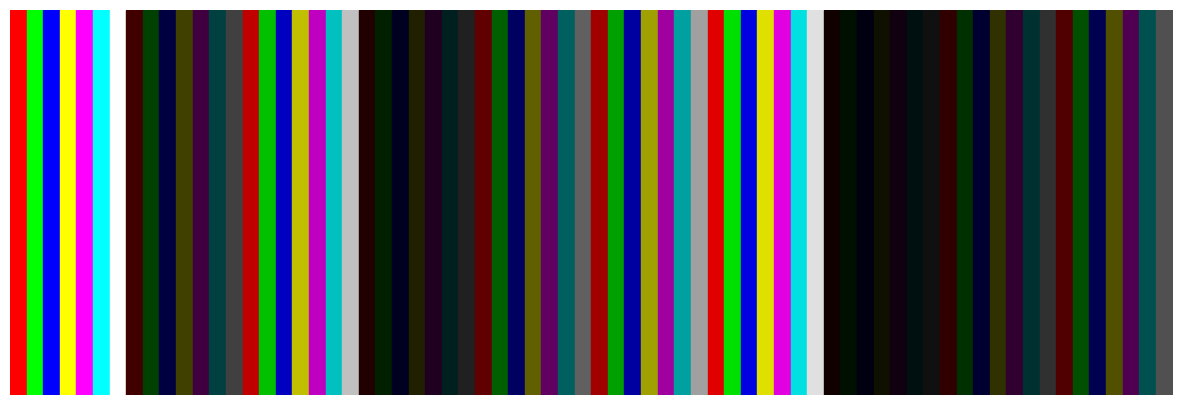

In [12]:
# Example usage
generator = ColourGenerator()
n = 70  # Number of colors to generate
distinct_colors = [generator.next_colour() for _ in range(n)]

for i, color in enumerate(distinct_colors):
    rgb_color = hex_to_rgb(color)
    print(f"Color {i}: {rgb_color}")

# Visualize the colors
plot_colors(distinct_colors)

/home/fradlin/miniconda3/envs/mask4d/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


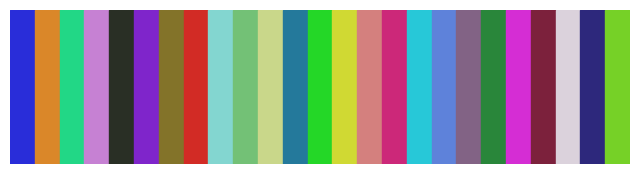

In [24]:
import numpy as np
from sklearn.cluster import KMeans


def generate_distinct_colors_kmeans(n):
    # Sample a large number of colors in RGB space
    np.random.seed(0)
    large_sample = np.random.randint(0, 256, (10000, 3))

    # Apply k-means clustering to find n clusters
    kmeans = KMeans(n_clusters=n).fit(large_sample)
    colors = kmeans.cluster_centers_.astype(int)

    return [tuple(color) for color in colors]


# Example usage
n = 25
distinct_colors_kmeans = generate_distinct_colors_kmeans(n)
# for i, color in enumerate(distinct_colors_kmeans):
#     print(f"Color {i}: {color}")

# Visualize the k-means colors
plot_colors(distinct_colors_kmeans)

70